In [1]:
import visdom
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import OrderedDict
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
# version: python3, pytorch 1.0

#【请先阅读以下内容】
#visdom的基础使用方法请参考：https://zhuanlan.zhihu.com/p/96551613
#简单来说即：
#第一步：运行命令行 python -m visdom.server (-port 【指定的端口名，如8888】)
#第二步：在code里启动visdom：
#   vis=Visdom(env="设置自己的环境名"，port=命令行设置的8888)
#第三步：在浏览器中输入 localhost:8888，就可以查看visdom的绘制
#
#
#PS：详细使用方法可以参考：https://github.com/facebookresearch/visdom




In [2]:
if not os.path.exists('./model/'):
    os.makedirs('./model/')

# run command: "python -m visdom.server"
viz = visdom.Visdom(env='originLoss',port=8097)

Setting up a new session...


In [3]:
# prepare data
best_acc = 0
data_train = MNIST('./data/mnist',
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor()]))
data_val = MNIST('./data/mnist',
                 train=False,
                 download=True,
                 transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor()]))
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_val_loader = DataLoader(data_val, batch_size=1024, num_workers=8)

In [4]:
len(data_train), len(data_val)

(60000, 10000)

In [5]:
# LeNet-5
class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    relu
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    relu
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

In [6]:
net = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=2e-3)

# for visualization
cur_batch_win = None
cur_batch_win_opts = {
    'title': 'Epoch Loss Trace',
    'xlabel': 'Batch Number',
    'ylabel': 'Loss',
    'width': 1200,
    'height': 600,
}

In [7]:
def train(epoch):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    for i, (images, labels) in enumerate(data_train_loader):
        optimizer.zero_grad()

        output = net(images)

        loss = criterion(output, labels)

        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)

        if i % 10 == 0:
            print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))

        # Update Visualization
        if viz.check_connection():
            cur_batch_win = viz.line(torch.Tensor(loss_list), torch.Tensor(batch_list),
                                     win=cur_batch_win, name='current_batch_loss',
                                     update=(None if cur_batch_win is None else 'replace'),
                                     opts=cur_batch_win_opts)

        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 优化器计算更新的步长，并与梯度一并更新网络参数


def validate():
    global best_acc
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    for i, (images, labels) in enumerate(data_val_loader):
        output = net(images)
        avg_loss += criterion(output, labels).sum()
        pred = output.detach().max(1)[1]  # detach cell from the model graph
        # print(pred)
        total_correct += pred.eq(labels.view_as(pred)).sum()

    avg_loss /= len(data_val)
    # the best score is Validation Avg. Loss: 0.000030, Accuracy: 0.990400
    print('Validation Avg. Loss: %f, Accuracy: %f' % (avg_loss.detach().cpu().item(), float(total_correct) / len(data_val)))
    if float(total_correct) / len(data_val) > best_acc:
        best_acc = float(total_correct) / len(data_val)
        torch.save(net.state_dict(), './model/best_model.pt')  # 保存当前模型所有参数至对应路径文件下

In [8]:
def main():
    for epoch in range(64):
        train(epoch)
        validate()

In [9]:
main()

Loss: 0.000009
Train - Epoch 46, Batch: 40, Loss: 0.000266
Train - Epoch 46, Batch: 50, Loss: 0.000130
Train - Epoch 46, Batch: 60, Loss: 0.000069
Train - Epoch 46, Batch: 70, Loss: 0.005632
Train - Epoch 46, Batch: 80, Loss: 0.000279
Train - Epoch 46, Batch: 90, Loss: 0.000040
Train - Epoch 46, Batch: 100, Loss: 0.001939
Train - Epoch 46, Batch: 110, Loss: 0.000012
Train - Epoch 46, Batch: 120, Loss: 0.000068
Train - Epoch 46, Batch: 130, Loss: 0.000055
Train - Epoch 46, Batch: 140, Loss: 0.000233
Train - Epoch 46, Batch: 150, Loss: 0.000671
Train - Epoch 46, Batch: 160, Loss: 0.001584
Train - Epoch 46, Batch: 170, Loss: 0.001400
Train - Epoch 46, Batch: 180, Loss: 0.000856
Train - Epoch 46, Batch: 190, Loss: 0.000023
Train - Epoch 46, Batch: 200, Loss: 0.000112
Train - Epoch 46, Batch: 210, Loss: 0.003189
Train - Epoch 46, Batch: 220, Loss: 0.000125
Train - Epoch 46, Batch: 230, Loss: 0.000318
Validation Avg. Loss: 0.000056, Accuracy: 0.990200
Train - Epoch 47, Batch: 0, Loss: 0.0012

# 1、修改代码使之完成奇偶数二分类问题

In [1]:
# tips：1、修改groundtruth："labels"值，如奇数为“1”，偶数为“0”；2、修改网络结构使之对应二分类问题而非10分类问题。
# result: Validation Avg. Loss: 0.000022, Accuracy: 0.993200
# code：
# LeNet-5
import visdom
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import OrderedDict
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
if not os.path.exists('./model/'):
    os.makedirs('./model/')
viz = visdom.Visdom()

best_acc = 0
data_train = MNIST('./data/mnist',
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor()]))
data_val = MNIST('./data/mnist',
                 train=False,
                 download=True,
                 transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor()]))
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_val_loader = DataLoader(data_val, batch_size=1024, num_workers=8)
class BinaryClassificationLeNet5(nn.Module):
    def __init__(self):
        super(BinaryClassificationLeNet5, self).__init__()
        #在这里补充你的代码
        #TODO
        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))
        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 10)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(10, 2)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))
    def forward(self, img):
        #在这里补充你的代码
        #TODO
        output=self.convnet(img)
        output=output.view(img.size()[0],-1)
        # print(output.size()[1])
        output=self.fc(output)
        return output
    
    
net = BinaryClassificationLeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=2e-3)

# for visualization
cur_batch_win = None
cur_batch_win_opts = {
    'title': 'Epoch Loss Trace',
    'xlabel': 'Batch Number',
    'ylabel': 'Loss',
    'width': 1200,
    'height': 600,
}
def train(epoch):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    for i, (images, labels) in enumerate(data_train_loader):
        labels%=2
        optimizer.zero_grad()

        output = net(images)

        loss = criterion(output, labels)

        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)

        if i % 10 == 0:
            print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))

        # Update Visualization
        if viz.check_connection():
            cur_batch_win = viz.line(torch.Tensor(loss_list), torch.Tensor(batch_list),
                                     win=cur_batch_win, name='current_batch_loss',
                                     update=(None if cur_batch_win is None else 'replace'),
                                     opts=cur_batch_win_opts)

        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 优化器计算更新的步长，并与梯度一并更新网络参数


def validate():
    global best_acc
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    for i, (images, labels) in enumerate(data_val_loader):
        labels%=2
        output = net(images)
        avg_loss += criterion(output, labels).sum()
        pred = output.detach().max(1)[1]  # detach cell from the model graph
        total_correct += pred.eq(labels.view_as(pred)).sum()

    avg_loss /= len(data_val)
    # the best score is Validation Avg. Loss: 0.000030, Accuracy: 0.990400
    print('Validation Avg. Loss: %f, Accuracy: %f' % (avg_loss.detach().cpu().item(), float(total_correct) / len(data_val)))
    if float(total_correct) / len(data_val) > best_acc:
        best_acc = float(total_correct) / len(data_val)
        torch.save(net.state_dict(), './model/best_model.pt')  # 保存当前模型所有参数至对应路径文件下
def main():
    for epoch in range(1, 16):
        train(epoch)
        validate()
main()

Setting up a new session...
Train - Epoch 1, Batch: 0, Loss: 0.729909
Train - Epoch 1, Batch: 10, Loss: 0.637968
Train - Epoch 1, Batch: 20, Loss: 0.510978
Train - Epoch 1, Batch: 30, Loss: 0.425568
Train - Epoch 1, Batch: 40, Loss: 0.326994
Train - Epoch 1, Batch: 50, Loss: 0.341513
Train - Epoch 1, Batch: 60, Loss: 0.202669
Train - Epoch 1, Batch: 70, Loss: 0.276595
Train - Epoch 1, Batch: 80, Loss: 0.270610
Train - Epoch 1, Batch: 90, Loss: 0.264134
Train - Epoch 1, Batch: 100, Loss: 0.190416
Train - Epoch 1, Batch: 110, Loss: 0.225955
Train - Epoch 1, Batch: 120, Loss: 0.161948
Train - Epoch 1, Batch: 130, Loss: 0.140453
Train - Epoch 1, Batch: 140, Loss: 0.131693
Train - Epoch 1, Batch: 150, Loss: 0.177328
Train - Epoch 1, Batch: 160, Loss: 0.129650
Train - Epoch 1, Batch: 170, Loss: 0.137430
Train - Epoch 1, Batch: 180, Loss: 0.112083
Train - Epoch 1, Batch: 190, Loss: 0.109821
Train - Epoch 1, Batch: 200, Loss: 0.078713
Train - Epoch 1, Batch: 210, Loss: 0.104848
Train - Epoch 1

# 2、优化

h: 20, Loss: 0.030430
Train - Epoch 46, Batch: 30, Loss: 0.027396
Train - Epoch 46, Batch: 40, Loss: 0.022066
Train - Epoch 46, Batch: 50, Loss: 0.016765
Train - Epoch 46, Batch: 60, Loss: 0.015650
Train - Epoch 46, Batch: 70, Loss: 0.039534
Train - Epoch 46, Batch: 80, Loss: 0.022528
Train - Epoch 46, Batch: 90, Loss: 0.028013
Train - Epoch 46, Batch: 100, Loss: 0.049742
Train - Epoch 46, Batch: 110, Loss: 0.016854
Train - Epoch 46, Batch: 120, Loss: 0.040398
Train - Epoch 46, Batch: 130, Loss: 0.030788
Train - Epoch 46, Batch: 140, Loss: 0.046459
Train - Epoch 46, Batch: 150, Loss: 0.082111
Train - Epoch 46, Batch: 160, Loss: 0.043456
Train - Epoch 46, Batch: 170, Loss: 0.020782
Train - Epoch 46, Batch: 180, Loss: 0.015961
Train - Epoch 46, Batch: 190, Loss: 0.071206
Train - Epoch 46, Batch: 200, Loss: 0.021867
Train - Epoch 46, Batch: 210, Loss: 0.023418
Train - Epoch 46, Batch: 220, Loss: 0.023509
Train - Epoch 46, Batch: 230, Loss: 0.015085
Validation Avg. Loss: 0.000019, Accuracy

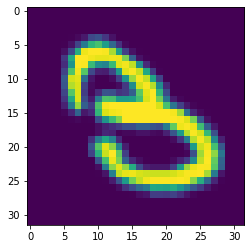

ans:3,pred:8


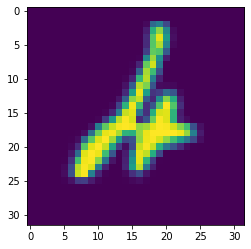

ans:4,pred:2


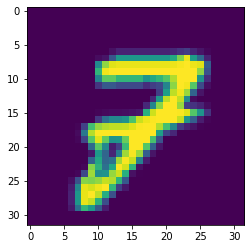

ans:7,pred:3


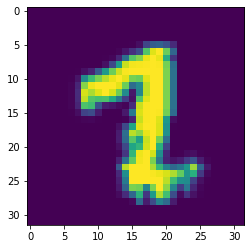

ans:2,pred:1


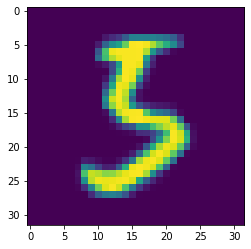

ans:5,pred:3


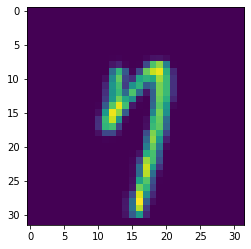

ans:7,pred:1


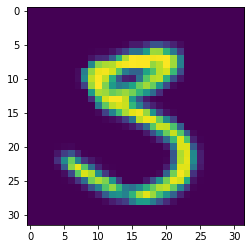

ans:3,pred:5


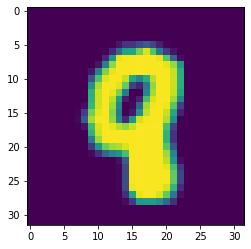

ans:8,pred:9


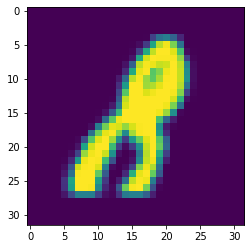

ans:8,pred:1


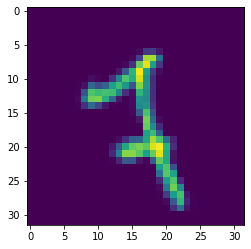

ans:7,pred:1


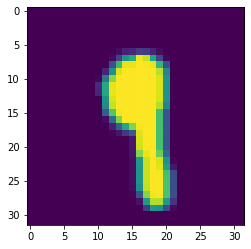

ans:9,pred:1


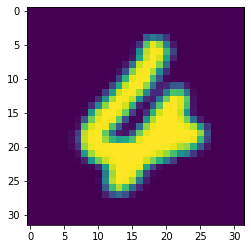

ans:4,pred:6


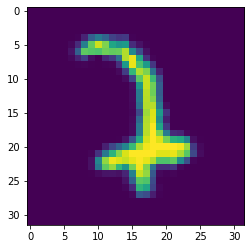

ans:7,pred:2


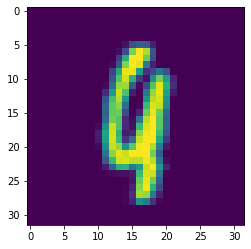

ans:9,pred:4


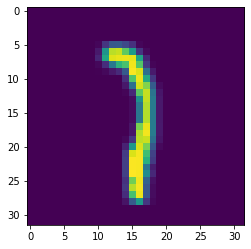

ans:7,pred:1


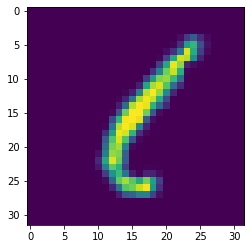

ans:1,pred:6


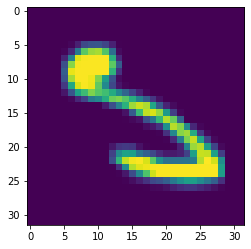

ans:5,pred:3


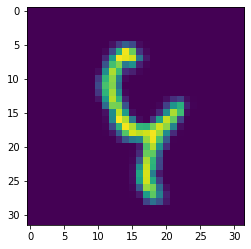

ans:9,pred:4


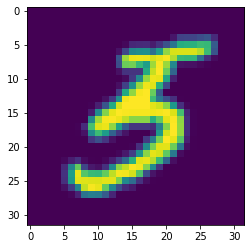

ans:5,pred:3


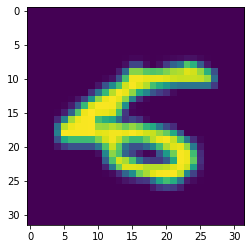

ans:5,pred:6


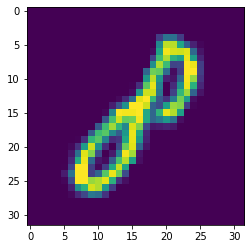

ans:8,pred:0


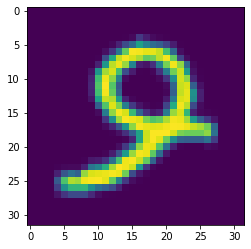

ans:9,pred:2


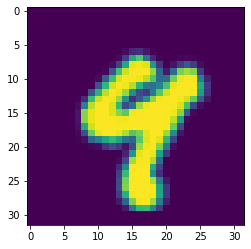

ans:4,pred:9


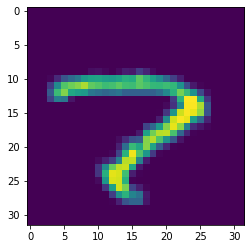

ans:7,pred:2


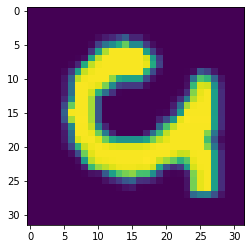

ans:9,pred:4


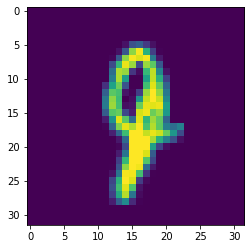

ans:9,pred:4


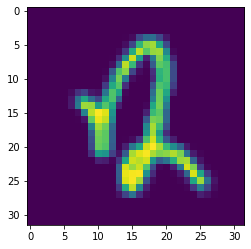

ans:2,pred:4


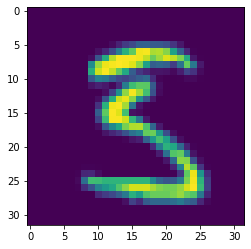

ans:5,pred:3


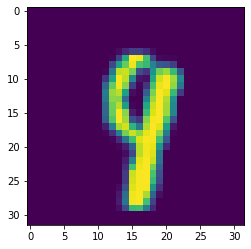

ans:9,pred:4


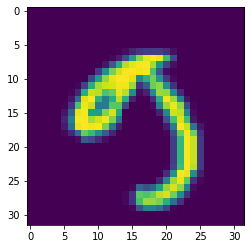

ans:9,pred:5


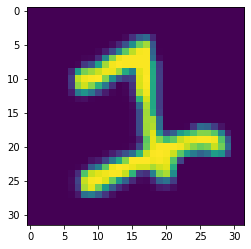

ans:1,pred:2


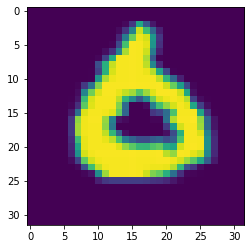

ans:6,pred:0


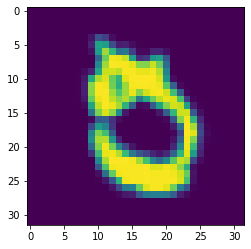

ans:5,pred:0


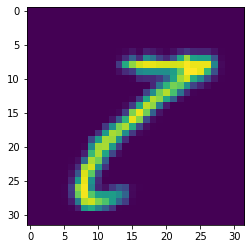

ans:7,pred:2


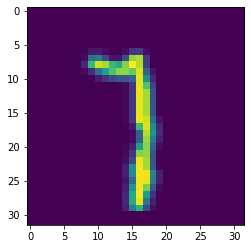

ans:7,pred:1


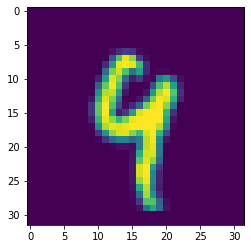

ans:9,pred:4


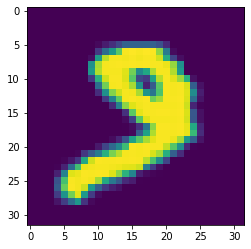

ans:9,pred:2


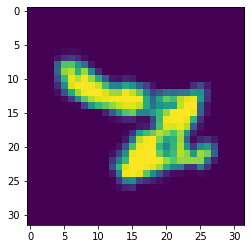

ans:2,pred:7


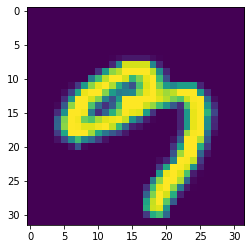

ans:9,pred:7


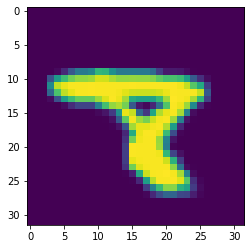

ans:8,pred:7


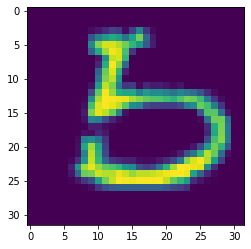

ans:5,pred:3


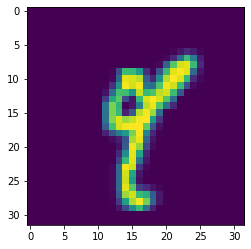

ans:9,pred:8


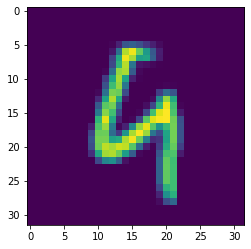

ans:9,pred:4


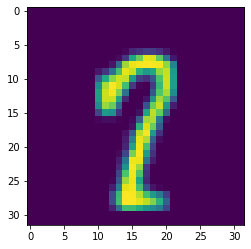

ans:7,pred:2


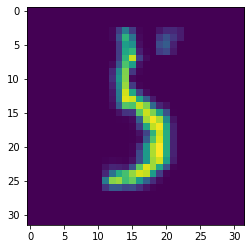

ans:5,pred:3


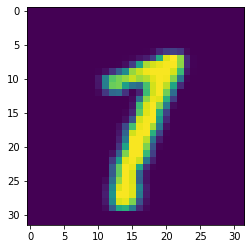

ans:7,pred:1


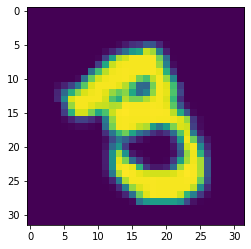

ans:3,pred:8


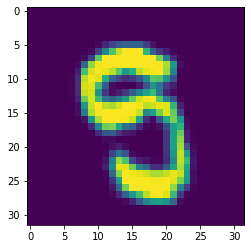

ans:5,pred:9


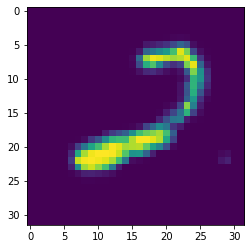

ans:2,pred:7


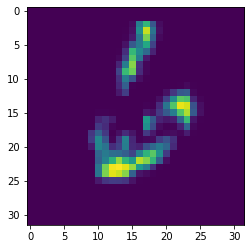

ans:6,pred:2


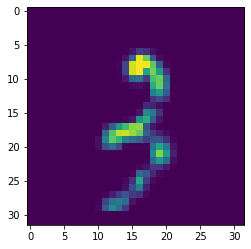

ans:3,pred:7


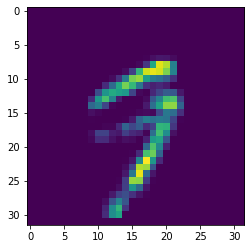

ans:9,pred:7


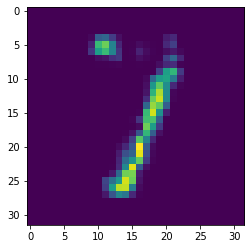

ans:7,pred:1


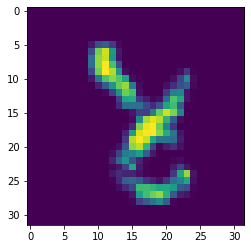

ans:8,pred:2


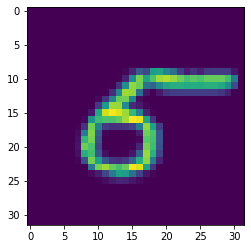

ans:5,pred:6


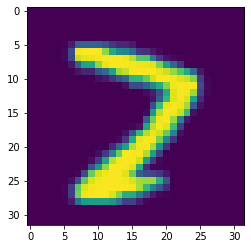

ans:7,pred:2


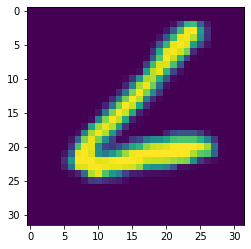

ans:6,pred:2


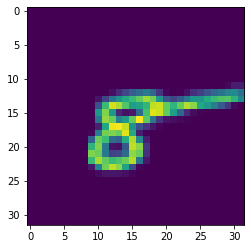

ans:8,pred:5


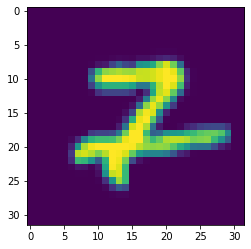

ans:7,pred:2


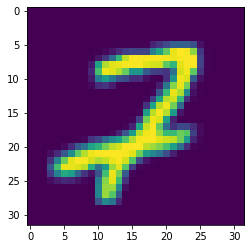

ans:7,pred:2


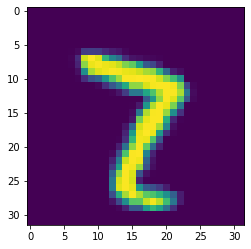

ans:7,pred:2


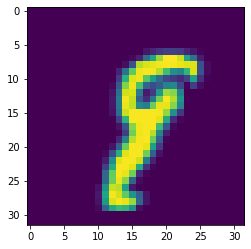

ans:9,pred:8


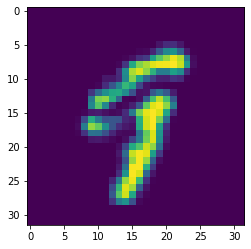

ans:9,pred:1


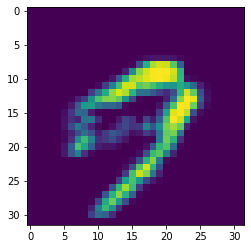

ans:9,pred:7


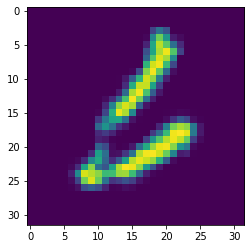

ans:6,pred:2


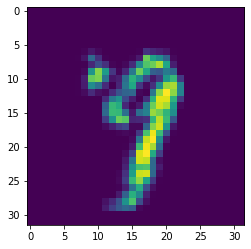

ans:9,pred:1


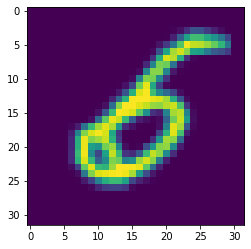

ans:5,pred:6


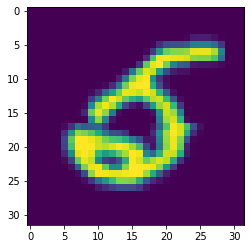

ans:5,pred:6


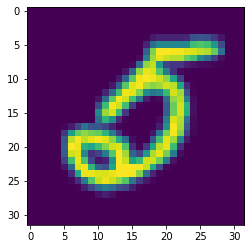

ans:5,pred:6
Validation Avg. Loss: 0.000021, Accuracy: 0.993100


In [5]:
# tips：利用各种方式提升模型准确率，如修改超参、调整网络结构、或做数据增强
# tips: 优化的目标：1、从效果上优化 2、从速度上优化
#
# code：
import visdom
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import OrderedDict
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
if not os.path.exists('./model/'):
    os.makedirs('./model/')
viz = visdom.Visdom()

best_acc = 0
data_train_1 = MNIST('./data/mnist',
                     download=True,
                     transform=transforms.Compose([
                         transforms.Resize((32, 32)),
                         transforms.ToTensor(),
                         #TODO
                         transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.8,1.2),shear=10,fillcolor=0)]))

data_val = MNIST('./data/mnist',
                 train=False,
                 download=True,
                 transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor()]))
#TODO
# print(data_train_1[1])
data_train_loader = DataLoader(data_train_1,batch_size=256,shuffle=True,num_workers=8)#此处可以考虑数据增强，比如合并，旋转，平移，构造一些新的数据。不做数据增强的话就复制上一题的代码在这里。

# for i in range(10):
#     plt.imshow(data_train_1[i][0].view(32,32))
#     plt.show()
data_val_loader = DataLoader(data_val, batch_size=1024, num_workers=8)
# print(data_val_loader.size())



class optimalLeNet5(nn.Module):
    def __init__(self):
        super(optimalLeNet5, self).__init__()
        #网络结构的优化，比如加入BN层？
        #TODO
        self.convnet = nn.Sequential(OrderedDict([
            ('bn0',nn.BatchNorm2d(1)),
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('bn1',nn.BatchNorm2d(6)),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('bn3',nn.BatchNorm2d(16)),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('bn5',nn.BatchNorm2d(120)),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            # ('bn5',nn.BatchNorm1d(120)),
            ('f6', nn.Linear(120, 84)),
            # ('bn6',nn.BatchNorm1d(84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))
    def forward(self, img):
        #TODO
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output
def init_parameters(n):
    if isinstance(n, nn.Linear):
        nn.init.xavier_uniform_(n.weight)

        
        
net = optimalLeNet5().cuda()
net.apply(init_parameters)
criterion = nn.CrossEntropyLoss()
#TODO
optimizer = optim.Adam(net.parameters(), lr=0.01)#尝试修改learningRate？换个optimizer？
# optimizer=optim.SGD(net.parameters(),lr=0.01)

# for visualization
cur_batch_win = None
cur_batch_win_opts = {
    'title': 'Epoch Loss Trace',
    'xlabel': 'Batch Number',
    'ylabel': 'Loss',
    'width': 1200,
    'height': 600,
}
def train(epoch):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    for i, (images, labels) in enumerate(data_train_loader):
        images=images.cuda()
        labels=labels.cuda()
        optimizer.zero_grad()
        print(images.shape)
        output = net(images)

        loss = criterion(output, labels)

        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)

        if i % 10 == 0:
            print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))

        # Update Visualization
        if viz.check_connection():
            cur_batch_win = viz.line(torch.Tensor(loss_list), torch.Tensor(batch_list),
                                     win=cur_batch_win, name='current_batch_loss',
                                     update=(None if cur_batch_win is None else 'replace'),
                                     opts=cur_batch_win_opts)

        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 优化器计算更新的步长，并与梯度一并更新网络参数

def validate(num):
    global best_acc
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    for i, (images, labels) in enumerate(data_val_loader):
        images=images.cuda()
        labels=labels.cuda()
        output = net(images)
        avg_loss += criterion(output, labels).sum()
        pred = output.detach().max(1)[1]  # detach cell from the model graph
        total_correct += pred.eq(labels.view_as(pred)).sum()
        if num==EPOCHS-1:
            for j,lb in enumerate(labels):
                if labels[j]!=pred[j]:
                    plt.imshow(images[j].cpu().view(32,32))
                    plt.show()
                    print(f'ans:{labels[j].item()},pred:{pred[j].item()}')
    avg_loss /= len(data_val)
    print('Validation Avg. Loss: %f, Accuracy: %f' % (avg_loss.detach().cpu().item(), float(total_correct) / len(data_val)))
    if float(total_correct) / len(data_val) > best_acc:
        best_acc = float(total_correct) / len(data_val)
        torch.save(net.state_dict(), './model/best_model.pt')  # 保存当前模型所有参数至对应路径文件下
EPOCHS=64
def main():
    #TODO
    for epoch in range(EPOCHS):
        global data_train_1,data_train_loader
        data_train_1 = MNIST('./data/mnist',
                     download=True,
                     transform=transforms.Compose([
                         transforms.Resize((32, 32)),
                         transforms.ToTensor(),
                         transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.8,1.2),shear=10,fillcolor=0)]))
        data_train_loader = DataLoader(data_train_1,batch_size=256,shuffle=True,num_workers=8)#此处可以考虑数据增强，比如合并，旋转，平移，构造一些新的数
        train(epoch)
        validate(epoch)
main()

## 主要的优化有几个方面：  
1. 每次训练前，在训练数据中加入随机噪声（仿射变换），如对图像随机旋转，平移，扭曲，缩放，以提高模型的泛化能力  
2. 在网络的Relu层之前加入BN层对权值标准化  
3. 使用cuda(gpu)代替cpu计算，完成16代训练仅需1分钟左右  
4. 将learningrate提高为0.01，加快了学习过程  
## 效果：
1. 16代训练的最高准确度大约为99.2%，而原模型仅为98.9%左右  
2. 64代训练的最高准确度约为99.4%，而原模型仅为99.1%左右  
3. 尝试跑了1024代训练，模型最高准确度达到99.71%，已将该网络模型保存在```胡晋侨-2000013141.pt```中